This is the document for our final project

In [18]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(stringr)
options(repr.matrix.max.rows = 6)

In [19]:
cleveland_heart_disease <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names=c("age", "sex", "cp", "trestbps", 
                                                                                                                                                    "chol", "fbs", "restecg", 
                                                                                                                                                    "thalach", "exang", "oldpeak", 
                                                                                                                                                    "slope", "ca", "thal", "num"))
cleveland_heart_disease

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


## Descriptions for Relevant Columns:
* age: age in years
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* thalach: maximum heart rate achieved
* num: diagnosis of heart disease (angiographic disease status)(0: no heart disease, 1-4: increasing severity)

In [20]:
cleveland_heart_disease$num <- str_replace(cleveland_heart_disease$num, "1", "yes")
cleveland_heart_disease$num <- str_replace(cleveland_heart_disease$num, "2", "yes")
cleveland_heart_disease$num <- str_replace(cleveland_heart_disease$num, "3", "yes")
cleveland_heart_disease$num <- str_replace(cleveland_heart_disease$num, "4", "yes")
cleveland_heart_disease$num <- str_replace(cleveland_heart_disease$num, "0", "no")

cleveland_heart_disease


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,no


In [21]:
cleveland_select <- cleveland_heart_disease %>%
    select(-sex, -fbs, -slope, -ca, -oldpeak, -thal, -cp, -restecg, -exang)%>%
    mutate(num = as_factor(num))
cleveland_select

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,no
67,160,286,108,yes
67,120,229,129,yes
⋮,⋮,⋮,⋮,⋮
57,130,131,115,yes
57,130,236,174,yes
38,138,175,173,no


In [22]:
set.seed(3546)

cleveland_split <- initial_split(cleveland_select, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,no
67,160,286,108,yes
56,120,236,178,no
⋮,⋮,⋮,⋮,⋮
68,144,193,141,yes
57,130,131,115,yes
38,138,175,173,no


## Training Data Information
The first table below shows the number patients that received each diagnosis.

The second shows the average value of each predictor.

The list displays the 5 column names in the training data.

In [23]:
cleveland_summarized <- cleveland_training %>%
group_by(num) %>%
dplyr::summarize(n = n())

cleveland_mean_predictors <- cleveland_training %>%
select(-num)%>%
map_df(mean)

cleveland_summarized
cleveland_mean_predictors
colnames(cleveland_training)

`summarise()` ungrouping output (override with `.groups` argument)



num,n
<fct>,<int>
no,123
yes,105


age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.52632,133.3421,245.7763,149.0132


[1] "age"      "trestbps" "chol"     "thalach"  "num"

## New Patient Data

In [24]:
new_patient <- tibble(age = 52, trestbps = 160, chol = 193, thalach = 155)
new_patient

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
52,160,193,155


In [25]:
set.seed(3546)

cleveland_recipe <- recipe(num ~ ., data = cleveland_training)%>%
step_scale(all_predictors())%>%
step_center(all_predictors())

training_scaled <- prep(cleveland_recipe, retain = TRUE)%>%
bake(cleveland_training)

training_scaled

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9275061,0.6748684,-0.2564349,0.04185359,no
1.3653351,1.5432091,0.8073342,-1.73943518,yes
0.1613054,-0.7723663,-0.1962216,1.22937944,no
⋮,⋮,⋮,⋮,⋮
1.4747923,0.6169790,-1.059280,-0.3398511,yes
0.2707627,-0.1934724,-2.303689,-1.4425537,yes
-1.8089250,0.2696427,-1.420560,1.0173212,no


## Graphs Depicting Predictors and their Effect on Diagnosis

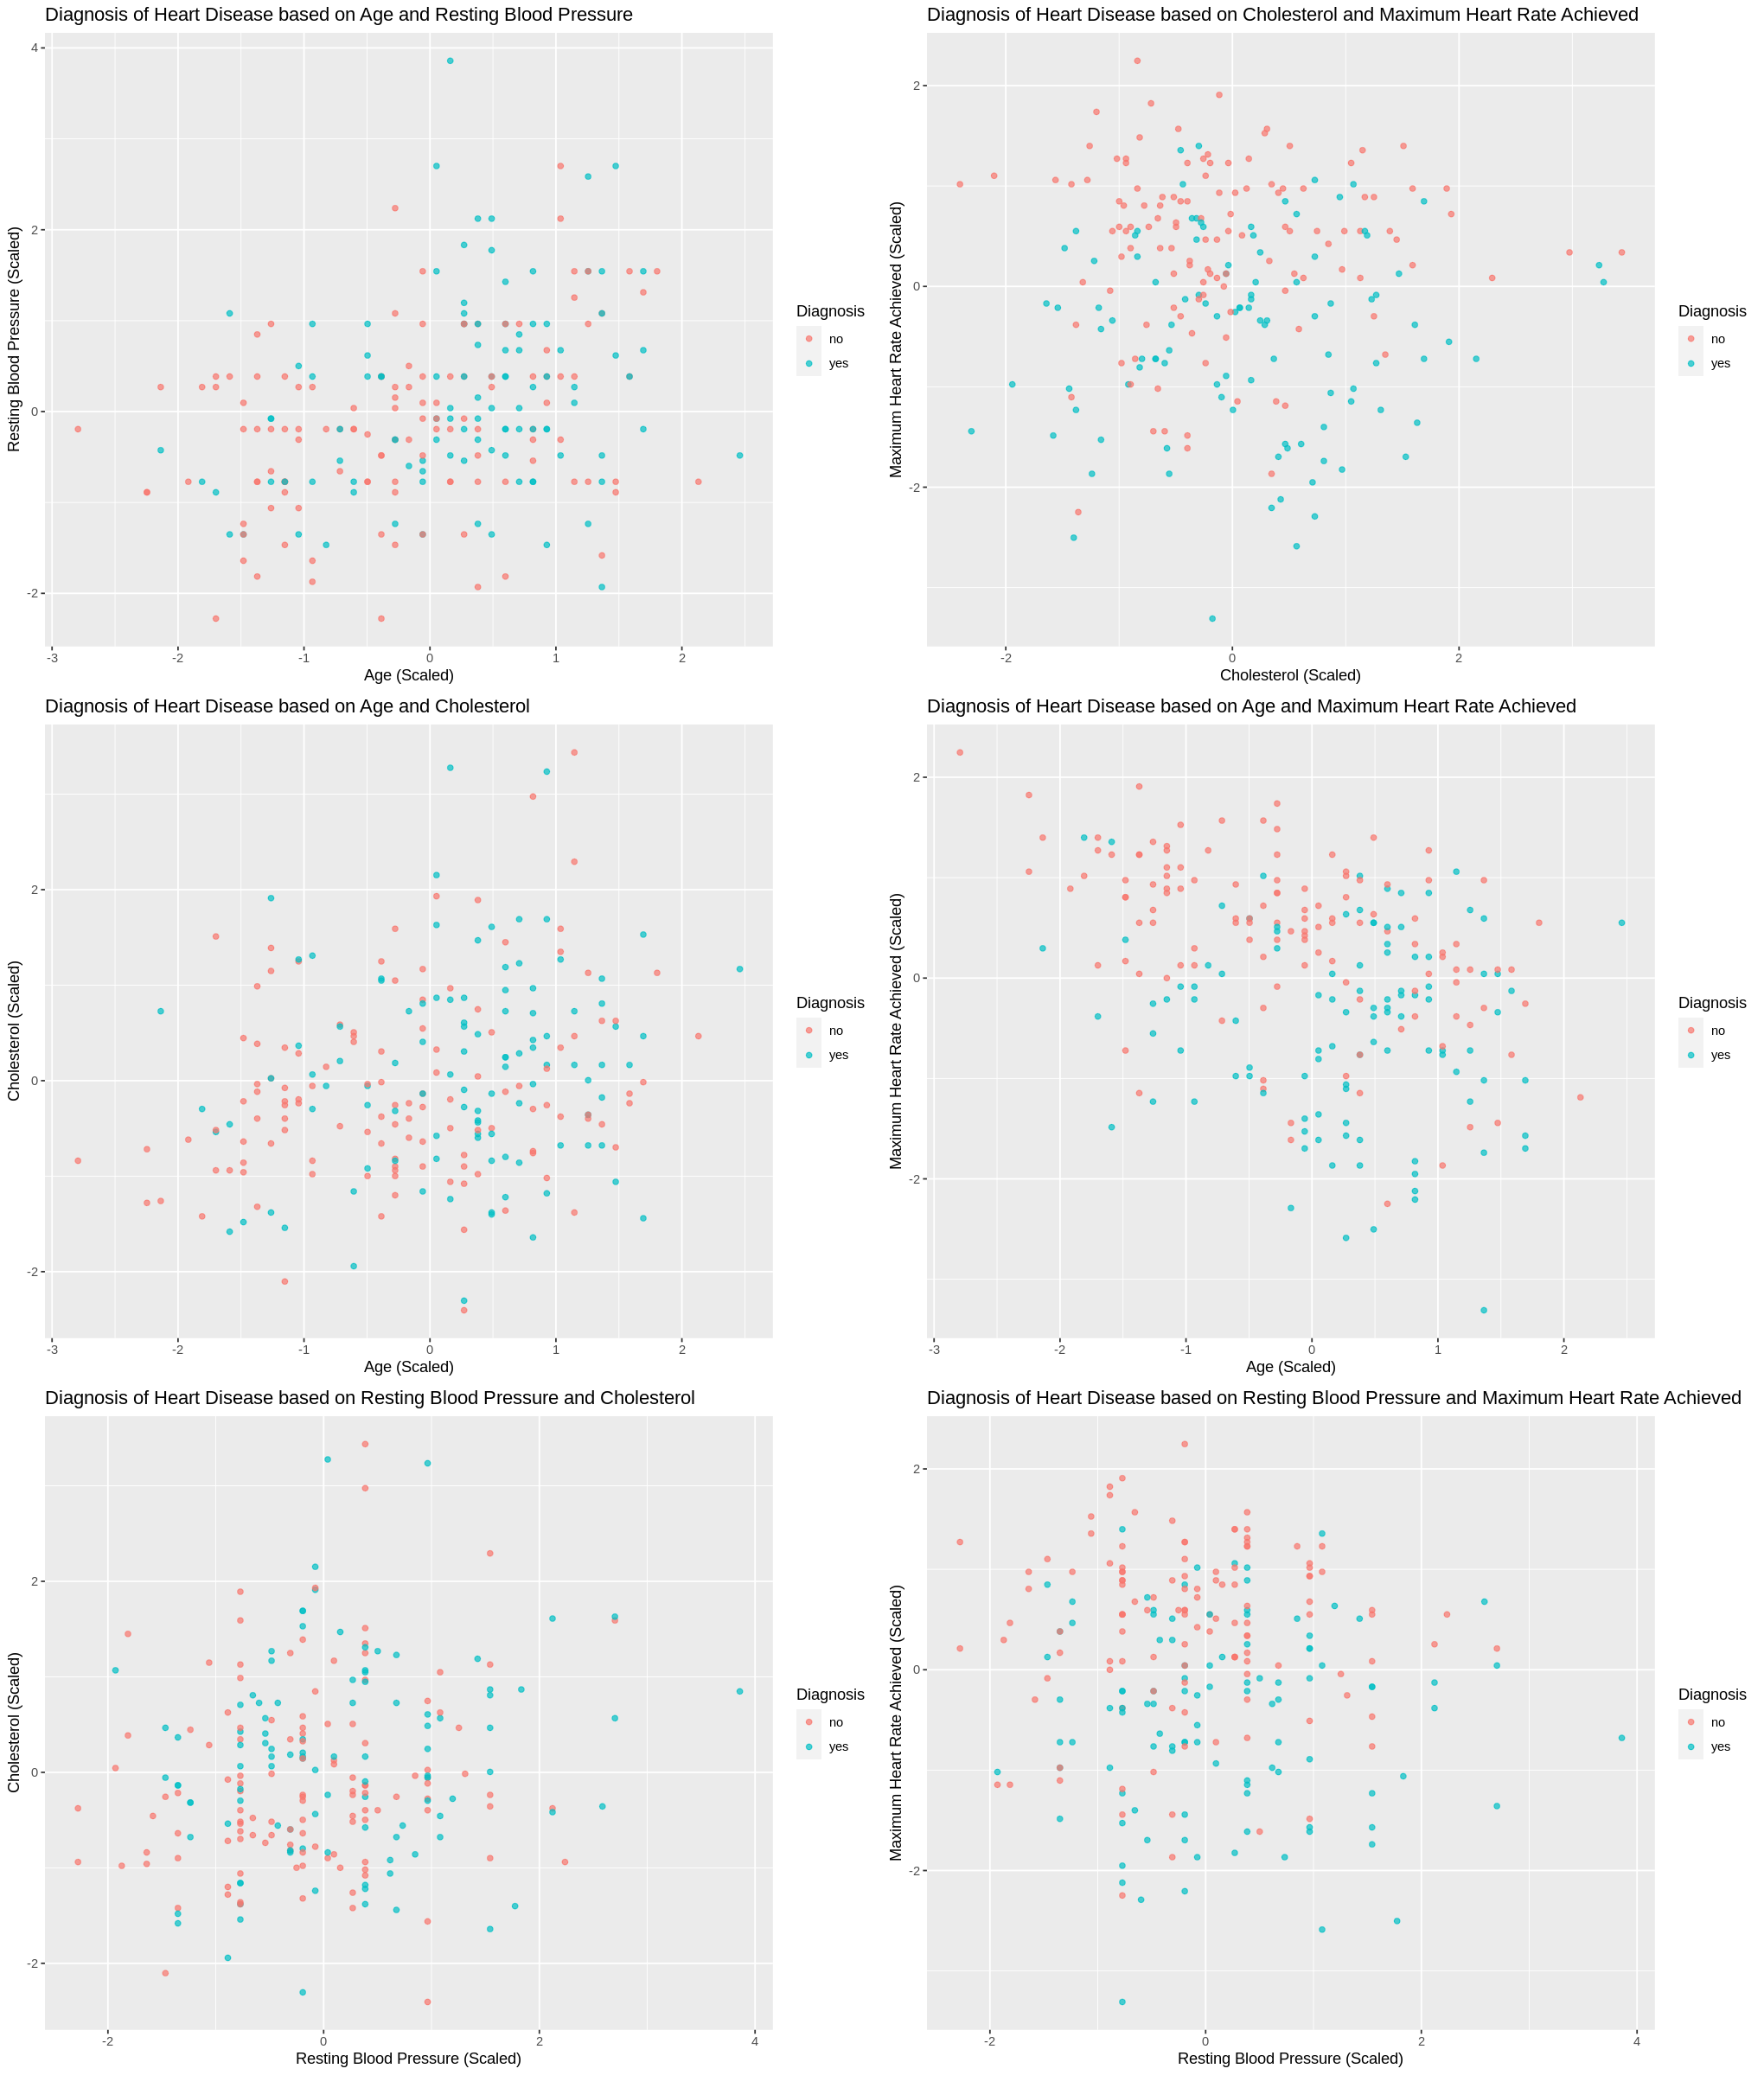

In [26]:
options(repr.plot.width = 17, repr.plot.height = 20)

cleveland_plot_1 <- training_scaled %>%
ggplot(aes(x=age, y=trestbps, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Age (Scaled)", y="Resting Blood Pressure (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Age and Resting Blood Pressure") 

cleveland_plot_2 <- training_scaled %>%
ggplot(aes(x=chol, y=thalach, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Cholesterol (Scaled)", y="Maximum Heart Rate Achieved (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Cholesterol and Maximum Heart Rate Achieved")

cleveland_plot_3 <- training_scaled %>%
ggplot(aes(x=age, y=chol, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Age (Scaled)", y="Cholesterol (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Age and Cholesterol")

cleveland_plot_4 <- training_scaled %>%
ggplot(aes(x=age, y=thalach, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Age (Scaled)", y="Maximum Heart Rate Achieved (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Age and Maximum Heart Rate Achieved")

cleveland_plot_5 <- training_scaled %>%
ggplot(aes(x=trestbps, y=chol, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Resting Blood Pressure (Scaled)", y="Cholesterol (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Resting Blood Pressure and Cholesterol")

cleveland_plot_6 <- training_scaled %>%
ggplot(aes(x=trestbps, y=thalach, colour=num)) +
geom_point(alpha = 0.7)+
labs(x="Resting Blood Pressure (Scaled)", y="Maximum Heart Rate Achieved (Scaled)", colour= "Diagnosis")+
ggtitle("Diagnosis of Heart Disease based on Resting Blood Pressure and Maximum Heart Rate Achieved")

plot_grid(cleveland_plot_1, cleveland_plot_2, cleveland_plot_3, cleveland_plot_4, cleveland_plot_5, cleveland_plot_6, ncol = 2)


In [27]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
                set_engine("kknn")%>%
                set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [28]:
cleveland_vfold <- vfold_cv(cleveland_training, v = 5, strata = num)

In [72]:
set.seed(3546)

gridvals <- tibble(neighbors = seq(from=1, to=35))

cleveland_results <- workflow() %>% 
                    add_recipe(cleveland_recipe) %>% 
                    add_model(knn_tune) %>% 
                    tune_grid(resamples = cleveland_vfold, grid = gridvals) %>% 
                    collect_metrics() %>% 
                    filter(.metric == "accuracy")

cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5568116,5,0.02690938,Model01
2,accuracy,binary,0.5568116,5,0.02690938,Model02
3,accuracy,binary,0.5960386,5,0.02539767,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
33,accuracy,binary,0.6758454,5,0.03328955,Model33
34,accuracy,binary,0.6758454,5,0.03328955,Model34
35,accuracy,binary,0.6583575,5,0.03320299,Model35


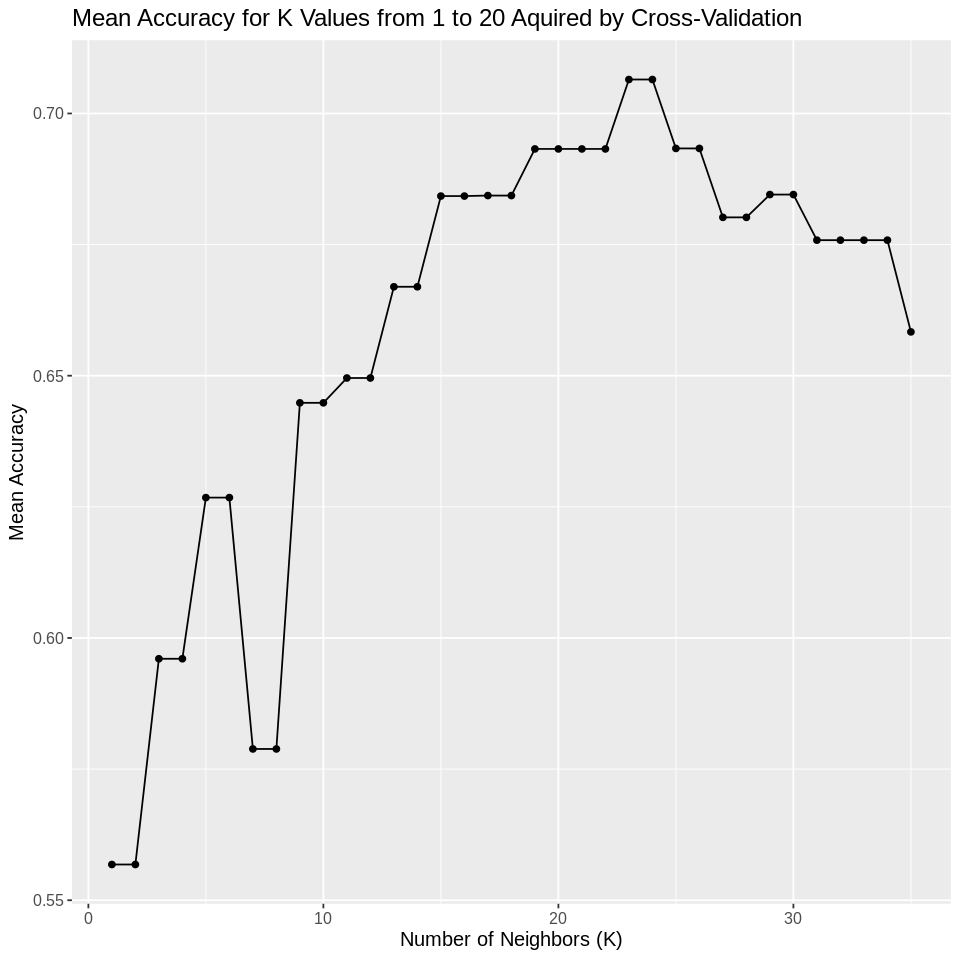

In [76]:
options(repr.plot.width = 8, repr.plot.height = 8)
k_val_plot <- cleveland_results %>%
ggplot(aes(x=neighbors, y=mean)) +
geom_point()+
geom_line()+
labs(x="Number of Neighbors (K)", y="Mean Accuracy")+
ggtitle("Mean Accuracy for K Values from 1 to 20 Aquired by Cross-Validation")+
theme(text=element_text(size=12))
k_val_plot

In [74]:
best_k_val <- cleveland_results %>%
    arrange(desc(mean))%>%
    slice(1)%>%
    pull(neighbors)
best_k_val

[1] 23

In [75]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_val) %>%
    set_engine("kknn")%>%
    set_mode("classification")

cleveland_fit <- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(knn_spec)%>%
    fit(cleveland_training)

cleveland_test <- cleveland_fit %>%
    predict(cleveland_testing) %>%
    bind_cols(cleveland_testing)%>%
    metrics(truth=num, estimate= .pred_class)

cleveland_accuracy <- cleveland_test %>%
    filter(.metric == "accuracy") %>%
    pull(.estimate)*100

cleveland_accuracy

[1] 73.33333